# SACOG Interview Assignment

Import Required Libraries

In [1]:
import pandas as pd
import requests
import json
import shapely
from shapely.geometry import Point, Polygon
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image

Get Data from API for Tasks 1 and 2

In [2]:
# Function to get data from the API
def get_data():
    url = "https://services.sacog.org/hosting/rest/services/Housing_Permit_Parcel_Points/FeatureServer/20/query"
    
    all_features = []
    result_offset = 0
    result_record_count = 1000
    
    while True:
        params = {
            "where": "1=1",
            "outFields": "*",
            "outSR": "4326",
            "f": "json",
            "resultOffset": result_offset,
            "resultRecordCount": result_record_count,
        }

        response = requests.get(url, params=params)
        
        if response.status_code == 200:
            features = json.loads(response.text)["features"]
            
            if not features:
                break
                
            all_features.extend(features)
            result_offset += result_record_count
        else:
            print(f"Error: {response.status_code}")
            break

    return all_features


# Get data from the API
features = get_data()

# Convert the list of dictionaries to a pandas DataFrame
data_ = pd.DataFrame(features)

data_attributes = pd.json_normalize(data_['attributes'])
data_geo = pd.json_normalize(data_['geometry'])
data = pd.concat([data_attributes, data_geo], axis=1)


# TASK 1

1) For each year (using the YEAR_ field) between 2010-2020: 
    
    a) Using the GLUC4 field, and excluding demolition permits (GLUC4 = “DEMO”), how many permits were solicited 
    for each housing type? 
    


In [3]:
data_1a = data[['YEAR_','UNITS', 'GLUC4', 'PERMITNUM', 'JURIS', 'SF_MF']]

*Assumption: SF_MF is the housing type - indicating Single Family/Multi Family units. GLUC4 is likely the permit type. This assumption was reached by reading this web page: 

*https://www.sacog.org/post/urban-structure > Housing Permit Parcel Points 2001-2014

In [5]:
# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data_1a.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

# Create a pivot table that groups the data by 'SF_MF' and displays the count of permits solicited for each year
result = pd.pivot_table(data_filtered, values='PERMITNUM', index=['SF_MF'], columns=['YEAR_'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total')

# Print the resulting pivot table

Q_1a = pd.DataFrame(result)
Q_1a

YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
SF_MF,,,,,,,,,,,,
MF24,32,16,13,28,54,18,43,60,36,69,16,378
MF5,56,41,23,38,15,31,29,44,44,91,59,468
SF,2271,1921,2028,2904,2620,3586,4360,5574,6667,6457,4766,43001
Total,2357,1978,2062,2967,2689,3635,4432,5678,6747,6617,4841,43840


In [6]:
Q1_a_summary_data = result.describe().astype(int)
Q1_a_summary_data

YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
count,4,4,4,4,4,4,4,4,4,4,4,4
mean,1179,989,1031,1484,1344,1817,2216,2839,3373,3308,2420,21921
std,1311,1109,1170,1675,1513,2070,2517,3218,3849,3728,2751,24827
min,32,16,13,28,15,18,29,44,36,69,16,378
25%,50,34,20,35,44,27,39,56,42,85,48,445
50%,1163,981,1025,1471,1337,1808,2201,2817,3355,3274,2412,21734
75%,2292,1935,2036,2919,2637,3598,4378,5600,6687,6497,4784,43210
max,2357,1978,2062,2967,2689,3635,4432,5678,6747,6617,4841,43840


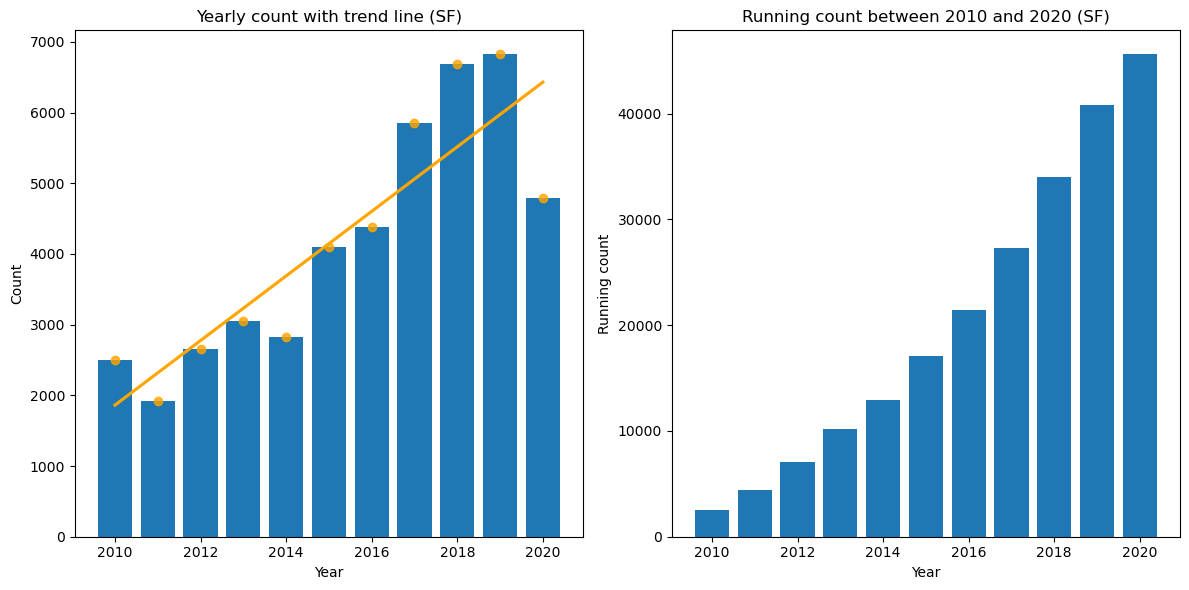

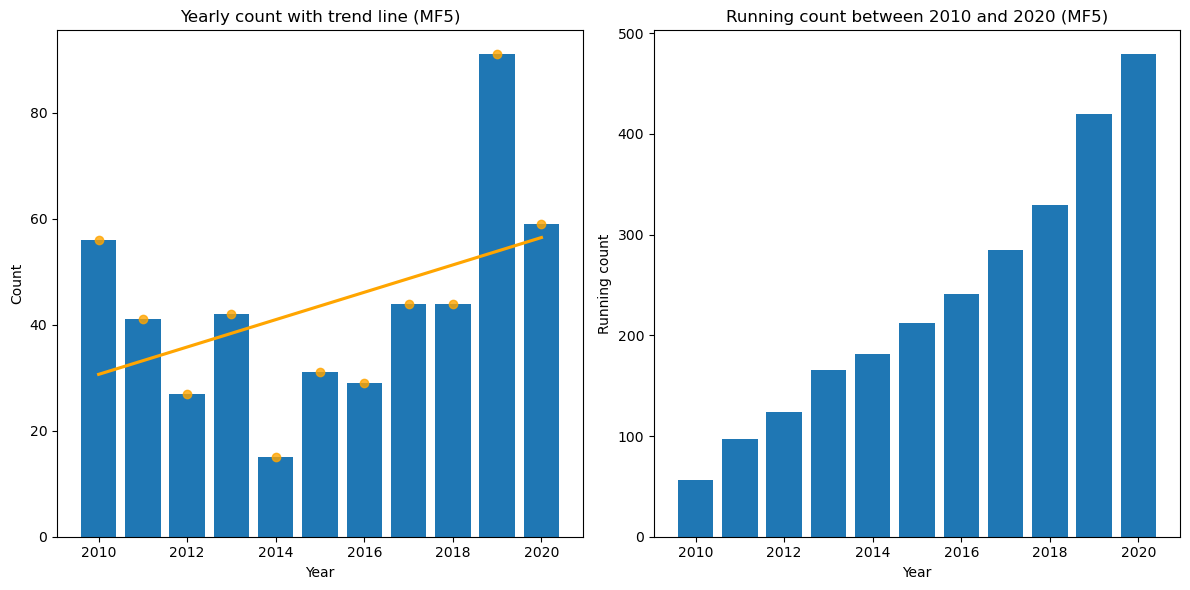

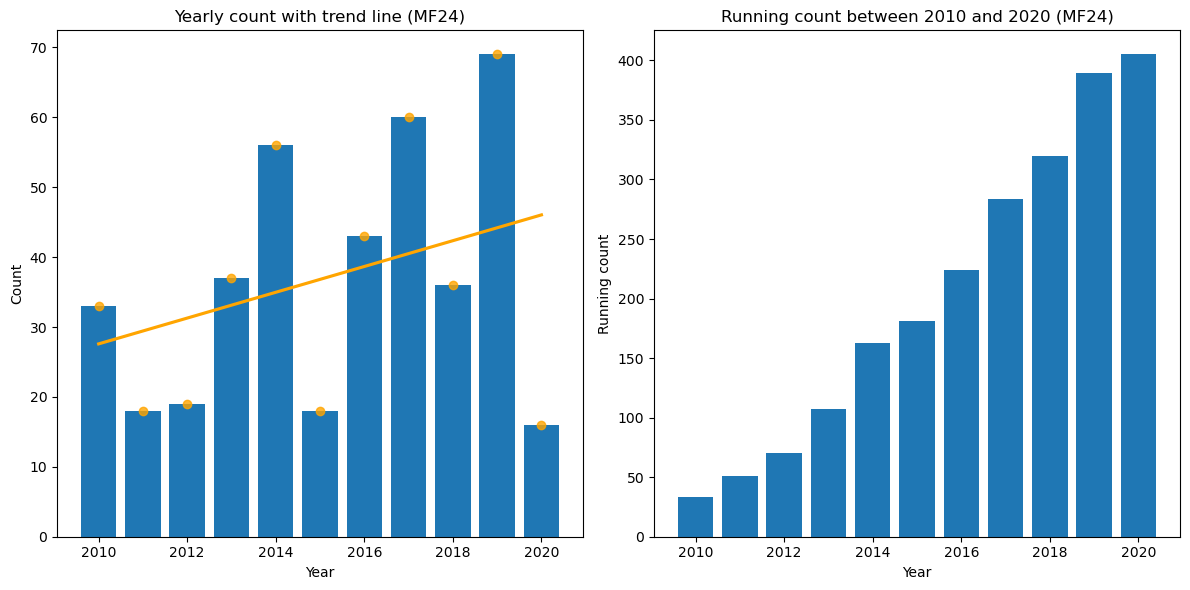

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data_1a.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

# Get the unique GLUC4 types
gluc4_types = data_filtered['SF_MF'].unique()

# Create two subplots for each GLUC4 type
for gluc4 in gluc4_types:
    # Filter the DataFrame by GLUC4
    data_gluc4 = data_filtered[data_filtered['SF_MF'] == gluc4]
    
    # Compute the yearly count and the running count by year
    yearly_count = data_gluc4.groupby('YEAR_')['UNITS'].count()
    running_count = yearly_count.cumsum()
    
    # Create the first subplot for yearly counts with a trend line
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.bar(yearly_count.index, yearly_count.values)
    sns.regplot(x=yearly_count.index, y=yearly_count.values, ax=ax1, ci=None, color='orange')
    ax1.set_title(f'Yearly count with trend line ({gluc4})')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Count')
    
    # Create the second subplot for running counts
    ax2.bar(running_count.index, running_count.values)
    ax2.set_title(f'Running count between 2010 and 2020 ({gluc4})')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Running count')
    
    # Save the figure to a file
    fig.tight_layout()
    fig.savefig(f'{gluc4}.png')
    plt.show()


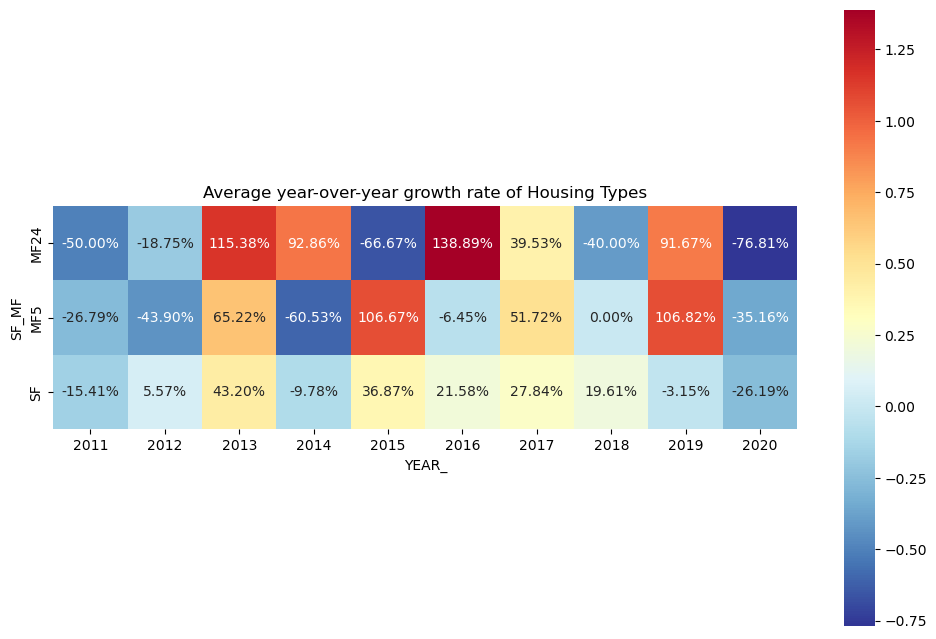

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data_1a.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert YEAR_ to integers
data_filtered['YEAR_'] = data_filtered['YEAR_'].astype(int)

# Group the data by GLUC4 and YEAR_ and compute the average number of permits
data_grouped = data_filtered.groupby(['SF_MF', 'YEAR_'])['PERMITNUM'].nunique().reset_index(name='count')
data_pivot = data_grouped.pivot(index='SF_MF', columns='YEAR_', values='count')

# Compute the year-over-year growth rates for each GLUC4 type
growth_rates = data_pivot.pct_change(axis='columns').iloc[:, 1:]

# Create a heat map of the growth rates
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(growth_rates.astype(float), cmap='RdYlBu_r', annot=True, fmt='.2%', square=True, ax=ax)

# Set the x-tick labels to integers
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Set the plot title
plt.title('Average year-over-year growth rate of Housing Types')

# Display the plot
plt.show()


b) Using the GLUC4 field and UNITS field, and assuming all permits are approved and  constructed, how many net units will be built for each housing type (i.e., new units net of  units that are removed through demolition)? 

*Assumption: SF_MF is the housing type - indicating Single Family/Multi Family units. GLUC4 is likely the permit type. This assumption was reached by reading this web page: 

*https://www.sacog.org/post/urban-structure > Housing Permit Parcel Points 2001-2014

In [9]:
# Create a new DataFrame with the desired subset of data
data_filtered = data_1a.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert the YEAR_ column to integer type
data_filtered['YEAR_'] = data_filtered['YEAR_'].astype(int)

# Create the pivot table with integer values
pivot_table = data_filtered.pivot_table(
    values='UNITS',
    index='SF_MF',
    columns='YEAR_',
    aggfunc='sum',
    margins=True
).astype(int)

# Print the pivot table
Q_1b = pd.DataFrame(pivot_table)
Q_1b

YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,All
SF_MF,,,,,,,,,,,,
MF24,74,51,53,112,122,38,91,120,73,139,32,905
MF5,753,690,831,917,506,630,840,838,1059,1593,1646,10303
SF,2505,1923,2662,3056,2825,4103,4376,5855,6681,6822,4794,45602
All,3332,2664,3546,4085,3453,4771,5307,6813,7813,8554,6472,56810


In [10]:
Q1_b_summary_data = pivot_table.describe().astype(int)
Q1_b_summary_data

YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,All
count,4,4,4,4,4,4,4,4,4,4,4,4
mean,1666,1332,1773,2042,1726,2385,2653,3406,3906,4277,3236,28405
std,1510,1179,1610,1843,1658,2396,2573,3415,3905,4045,2926,26996
min,74,51,53,112,122,38,91,120,73,139,32,905
25%,583,530,636,715,410,482,652,658,812,1229,1242,7953
50%,1629,1306,1746,1986,1665,2366,2608,3346,3870,4207,3220,27952
75%,2711,2108,2883,3313,2982,4270,4608,6094,6964,7255,5213,48404
max,3332,2664,3546,4085,3453,4771,5307,6813,7813,8554,6472,56810


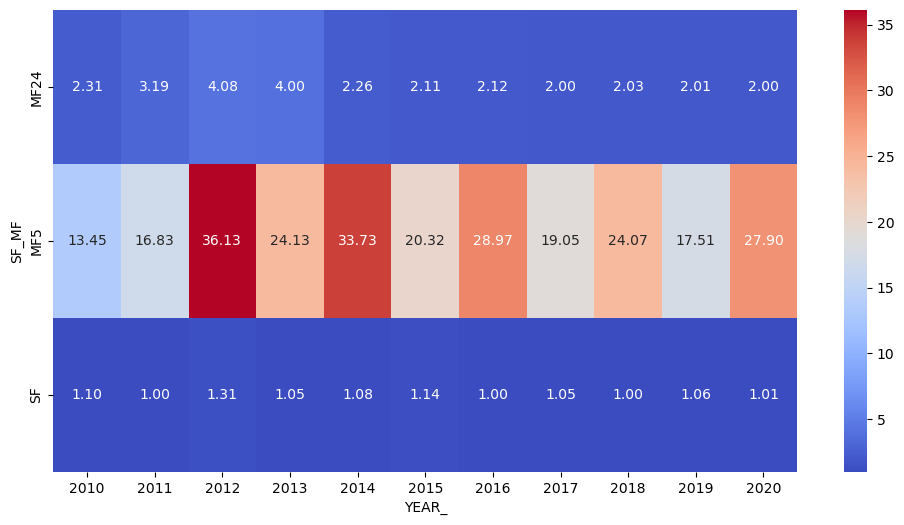

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average units per permit for each combination of SF_MF and YEAR_
data_grouped = data_filtered.groupby(['SF_MF', 'YEAR_']).agg({'UNITS': 'sum', 'PERMITNUM': 'nunique'})
data_grouped['AVG_UNITS_PER_PERMIT'] = data_grouped['UNITS'] / data_grouped['PERMITNUM']
data_grouped.reset_index(inplace=True)

# Create a pivot table of the average units per permit
pivot_table = data_grouped.pivot_table(
    values='AVG_UNITS_PER_PERMIT',
    index='SF_MF',
    columns='YEAR_',
    fill_value=0
)

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 6))

# Create the heat map using seaborn
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)

# Show the plot
plt.show()


# Question 2

Using the GLUC4, UNITS, and JURIS fields, how many net housing units (net of demolitions) did each  jurisdiction approve between 2010 and 2020? 


In [12]:
import pandas as pd

# Assume you have a pandas DataFrame called 'data'

# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Group the data by GLUC4, JURIS, and YEAR_ and compute the sum of UNITS for each group
net_units = data_filtered.groupby(['JURIS'])['UNITS'].sum().reset_index()

# Convert the 'UNITS' column to integers
net_units['UNITS'] = net_units['UNITS'].astype(int)

# Compute the total net units across all jurisdictions
total_net_units = net_units['UNITS'].sum()

# Append the total to the DataFrame
net_units = net_units.append({'JURIS': 'Total', 'UNITS': total_net_units}, ignore_index=True)

# Print the net units for each jurisdiction
pd.DataFrame(net_units)


/var/folders/90/06jx2f8j2qq_tkqnn3_54fg40000gn/T/ipykernel_1955/3814213694.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  net_units = net_units.append({'JURIS': 'Total', 'UNITS': total_net_units}, ignore_index=True)


,JURIS,UNITS
0,AUBURN,296
1,CITRUS HEIGHTS,188
2,COLFAX,4
3,DAVIS,1054
4,EL DORADO COUNTY,3908
5,ELK GROVE,5762
6,FOLSOM,3683
7,GALT,515
8,ISLETON,11
9,LINCOLN,1949


# Task 3: 
**Extra credit – Using the API for SACOG’s counties (shown below), figure out which county each  permit was issued in and show how many permits were issued in each county between 2010-2020.

In [22]:
import requests
import json

# make a request to the URL and get the JSON data
url = 'https://services6.arcgis.com/YBp5dUuxCMd8W1EI/arcgis/rest/services/Counties/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
response = requests.get(url)
json_data = json.loads(response.text)

# create a dictionary to store the outermost points for each county
county_dict = {}

# loop through each feature and find the outermost points
for feature in json_data['features']:
    county_name = feature['attributes']['COUNTY_NAM']
    county_boundaries = feature['geometry']['rings']

    # initialize variables to store the outermost points
    min_lon = float('inf')
    max_lon = float('-inf')
    min_lat = float('inf')
    max_lat = float('-inf')

    # loop through each ring and find the outermost points
    for ring in county_boundaries:
        for point in ring:
            lon, lat = point
            if lon < min_lon:
                min_lon = lon
            if lon > max_lon:
                max_lon = lon
            if lat < min_lat:
                min_lat = lat
            if lat > max_lat:
                max_lat = lat

    # add the outermost points to the dictionary for the county
    county_dict[county_name] = ((min_lon, min_lat), (max_lon, max_lat))

county_dict

{'Yuba': ((-121.636094303965, 38.9183987915514),
  (-121.009489129948, 39.6396072262018)),
 'Placer': ((-121.484452101151, 38.71137435993),
  (-120.002476017499, 39.3164500245933)),
 'Sutter': ((-121.948303982183, 38.734582714418),
  (-121.414487160201, 39.3054593369948)),
 'El Dorado': ((-121.148990937667, 38.5024286556686),
  (-119.877261864068, 39.0674885483529)),
 'Yolo': ((-122.422062990819, 38.3130418079634),
  (-121.501104946819, 38.9260358212458)),
 'Sacramento': ((-121.863078097369, 38.0181385611437),
  (-121.022533170032, 38.7359524284132))}

In [25]:
# Add a new column to the data DataFrame to store the county for each permit
data['county'] = ''

# Loop through each permit and find the county it is in
for index, row in data.iterrows():
    permit_location = Point(row['x'], row['y'])
    found_county = False
    
    # Check if the permit is within a county polygon
    for county_name, county_points in county_dict.items():
        (min_lon, min_lat), (max_lon, max_lat) = county_points
        if row['x'] >= min_lon and row['x'] <= max_lon and row['y'] >= min_lat and row['y'] <= max_lat:
            data.at[index, 'county'] = county_name
            found_county = True
            break
    
    # Print a warning message if the permit is not within any county
    if not found_county:
        print(f"Warning: Permit {row['PERMITNUM']} not within any county.")


In [27]:
# Filter on the rows with YEAR_ between 2010-2020 and exclude GLUC4 values of Demo
data_filtered = data.query('GLUC4 != "DEMO" and YEAR_.between(2010, 2020)').copy()

# Convert the 'YEAR_' column to integers
data_filtered.loc[:, 'YEAR_'] = data_filtered['YEAR_'].astype(np.int64)

# Create a pivot table that groups the data by 'SF_MF' and displays the count of permits solicited for each year
result = pd.pivot_table(data_filtered, values='PERMITNUM', index=['county'], columns=['YEAR_'], aggfunc=pd.Series.nunique, margins=True, margins_name='Total')

# Print the resulting pivot table
pd.DataFrame(result)


YEAR_,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total
county,,,,,,,,,,,,
El Dorado,148,100,201,402,447,466,135,770,639,815,580,4699
Placer,814,794,997,867,1018,1591,1757,2050,2494,1875,1939,16135
Sacramento,884,736,610,1316,771,1041,1373,1425,1825,1987,1413,13363
Sutter,67,37,19,21,35,50,41,21,43,107,51,490
Yolo,254,168,143,270,242,279,868,1219,1313,1335,349,6433
Yuba,192,143,94,94,182,213,272,197,439,516,509,2847
Total,2357,1978,2062,2967,2689,3635,4432,5678,6747,6617,4841,43840


# Recommendations:


Based on the analysis above, I would provide the following recommendations:

1. Focus on increasing affordable housing: The analysis shows that the majority of permits are for single-family housing types, which tend to be more expensive. It is important to encourage the development of more affordable housing types, such as multi-family housing, to accommodate diverse income groups and address housing affordability challenges in the region.


2. Encourage higher-density development: To maximize land use efficiency and reduce urban sprawl, it is important to promote higher-density housing types, such as multi-family and mixed-use developments. This can be achieved through zoning changes, incentives, and public-private partnerships.


3. Streamline the permitting process: Reducing the time and cost associated with obtaining permits can encourage more housing development and help meet the increasing demand for housing in the region. Streamlining the permitting process can include measures such as simplifying zoning codes, digitizing the permit application process, and providing more resources for planning departments.


4. Monitor demolition trends: The analysis shows that there are some demolitions happening, leading to a net decrease in housing units. It is important to monitor these trends and identify the reasons for demolitions, whether it is due to deteriorating housing stock, land use changes, or other factors. This information can help inform policies to minimize unnecessary loss of housing units.


5. Collaborate with jurisdictions: The analysis shows that the number of net housing units approved varies by jurisdiction. It is essential to collaborate with individual jurisdictions to identify local challenges and opportunities in housing development and work together to create policies and programs that support the regional housing goals.




